In [2]:
import mesa
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [3]:
class ArmAgent(mesa.Agent):
    """An agent representing an arm in the multi-armed bandit problem."""
    
    def __init__(self, unique_id, model, true_mean, true_std):
        super().__init__(unique_id, model)
        self.true_mean = true_mean
        self.true_std = true_std
    
    def pull(self):
        """Pull the arm and return a reward."""
        return np.random.normal(self.true_mean, self.true_std)

In [4]:
class BanditAgent(mesa.Agent):
    """An agent representing the bandit in the multi-armed bandit problem."""
    
    def __init__(self, unique_id, model, strategy='epsilon_greedy', epsilon=0.1):
        super().__init__(unique_id, model)
        self.strategy = strategy
        self.epsilon = epsilon
        self.values = {arm.unique_id: 0 for arm in self.model.arms}
        self.counts = {arm.unique_id: 0 for arm in self.model.arms}
        self.cumulative_reward = 0
    
    def select_arm_random(self):
        """Select an arm randomly."""
        return self.random.choice(self.model.arms)
    
    def select_arm_greedy(self):
        """Select the arm with the highest estimated value."""
        return max(self.model.arms, key=lambda arm: self.values[arm.unique_id])
    
    def select_arm_epsilon_greedy(self):
        """Select an arm using epsilon-greedy strategy."""
        if self.random.random() < self.epsilon:
            return self.select_arm_random()
        else:
            return self.select_arm_greedy()
    
    def select_arm(self):
        """Select an arm based on the current strategy."""
        if self.strategy == 'random':
            return self.select_arm_random()
        elif self.strategy == 'greedy':
            return self.select_arm_greedy()
        elif self.strategy == 'epsilon_greedy':
            return self.select_arm_epsilon_greedy()
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
    
    def update(self, chosen_arm, reward):
        """Update the estimated value of the chosen arm."""
        arm_id = chosen_arm.unique_id
        self.counts[arm_id] += 1
        n = self.counts[arm_id]
        value = self.values[arm_id]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[arm_id] = new_value
        self.cumulative_reward += reward
    
    def step(self):
        """Perform one step of the bandit algorithm."""
        chosen_arm = self.select_arm()
        reward = chosen_arm.pull()
        self.update(chosen_arm, reward)

In [5]:
class MABModel(mesa.Model):
    """A model for the multi-armed bandit problem."""
    
    def __init__(self, arms, bandit_strategy='epsilon_greedy'):
        self.num_arms = len(arms)
        self.schedule = mesa.time.RandomActivation(self)
        
        # Use the provided arms
        self.arms = arms
        for arm in self.arms:
            self.schedule.add(arm)
        
        # Create bandit
        bandit = BanditAgent(self.num_arms, self, strategy=bandit_strategy)
        self.schedule.add(bandit)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Cumulative Reward": lambda m: m.schedule.agents[-1].cumulative_reward,
                "Strategy": lambda m: m.schedule.agents[-1].strategy
            },
            agent_reporters={}
        )
    
    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
def visualize_true_distributions(arms):
    plt.figure(figsize=(12, 6))
    x = np.linspace(-5, 5, 1000)
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(arms)))
    
    for i, (arm, color) in enumerate(zip(arms, colors)):
        y = norm.pdf(x, arm.true_mean, arm.true_std)
        plt.plot(x, y, label=f'Arm {i} (μ={arm.true_mean:.2f}, σ={arm.true_std:.2f})', color=color)
        
        # Add vertical line at the mean
        plt.axvline(x=arm.true_mean, color=color, linestyle='--', alpha=0.7)
    
    plt.title("True Reward Distributions for Each Arm")
    plt.xlabel("Reward")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [7]:
# Create arms with different true means and standard deviations
arms = [
    ArmAgent(0, None, 0.0, 1),
    ArmAgent(1, None, 0.5, 1),
    ArmAgent(2, None, 1.0, 1),
    ArmAgent(3, None, 1.5, 1),
    ArmAgent(4, None, 2.0, 1)
]

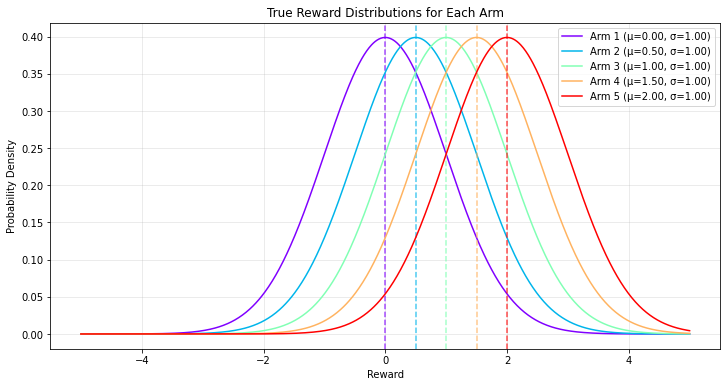

In [8]:
# Visualize the true reward distributions
visualize_true_distributions(arms)

In [9]:
# Simulation parameters
num_steps = 1000
strategies = ['random', 'greedy', 'epsilon_greedy']

In [10]:
# Run simulations for each strategy
results = {}
models = {}

for strategy in strategies:
    model = MABModel(arms, bandit_strategy=strategy)
    for _ in range(num_steps):
        model.step()
    
    results[strategy] = model.datacollector.get_model_vars_dataframe()
    models[strategy] = model

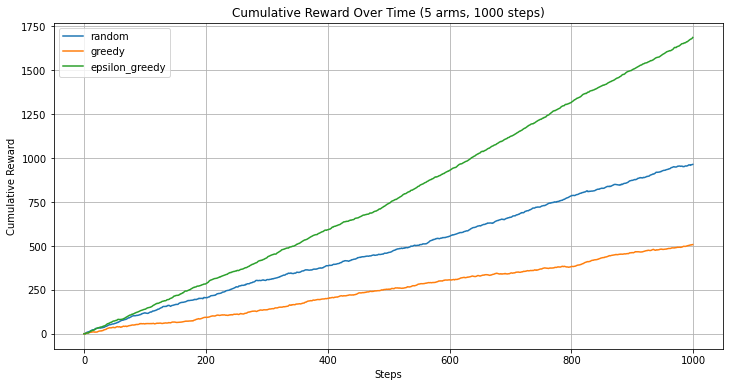

In [11]:
# Plot cumulative reward over time
plt.figure(figsize=(12, 6))
for strategy, data in results.items():
    plt.plot(data['Cumulative Reward'], label=strategy)

plt.title(f"Cumulative Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

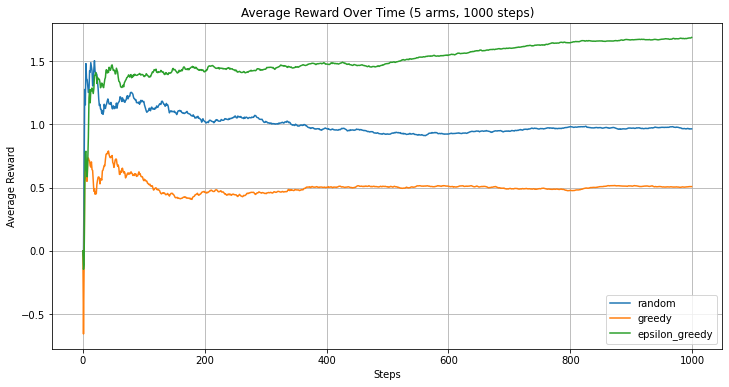

In [12]:
# Plot average reward over time
plt.figure(figsize=(12, 6))
for strategy, data in results.items():
    average_reward = data['Cumulative Reward'] / (np.arange(len(data)) + 1)
    plt.plot(average_reward, label=strategy)

plt.title(f"Average Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

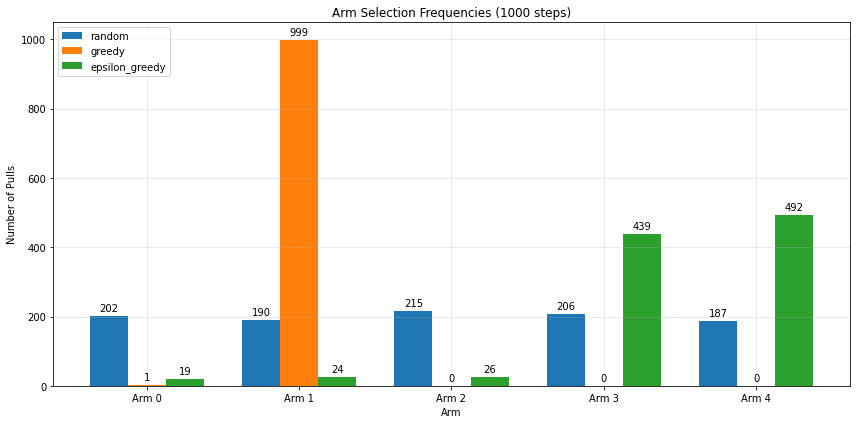

In [13]:
# Plot arm selection frequencies
plt.figure(figsize=(12, 6))
x = np.arange(len(arms))
bar_width = 0.25
multiplier = 0

for strategy, model in models.items():
    bandit = model.schedule.agents[-1]
    arm_pulls = list(bandit.counts.values())
    offset = bar_width * multiplier
    rects = plt.bar(x + offset, arm_pulls, bar_width, label=strategy)
    plt.bar_label(rects, padding=3)
    multiplier += 1

plt.title(f"Arm Selection Frequencies ({num_steps} steps)")
plt.xlabel("Arm")
plt.ylabel("Number of Pulls")
plt.xticks(x + bar_width, [f"Arm {i}" for i in range(len(arms))])
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Print final arm values and counts for each strategy
for strategy, model in models.items():
    print(f"\nFinal arm values and counts for {strategy} strategy:")
    bandit = model.schedule.agents[-1]
    for arm in model.arms:
        print(f"Arm {arm.unique_id}: True mean = {arm.true_mean:.2f}, "
              f"Estimated value = {bandit.values[arm.unique_id]:.2f}, "
              f"Pull count = {bandit.counts[arm.unique_id]}")
    print(f"Total reward: {bandit.cumulative_reward:.2f}")


Final arm values and counts for random strategy:
Arm 0: True mean = 0.00, Estimated value = -0.11, Pull count = 202
Arm 1: True mean = 0.50, Estimated value = 0.49, Pull count = 190
Arm 2: True mean = 1.00, Estimated value = 0.92, Pull count = 215
Arm 3: True mean = 1.50, Estimated value = 1.46, Pull count = 206
Arm 4: True mean = 2.00, Estimated value = 2.13, Pull count = 187
Total reward: 965.84

Final arm values and counts for greedy strategy:
Arm 0: True mean = 0.00, Estimated value = -1.32, Pull count = 1
Arm 1: True mean = 0.50, Estimated value = 0.51, Pull count = 999
Arm 2: True mean = 1.00, Estimated value = 0.00, Pull count = 0
Arm 3: True mean = 1.50, Estimated value = 0.00, Pull count = 0
Arm 4: True mean = 2.00, Estimated value = 0.00, Pull count = 0
Total reward: 510.07

Final arm values and counts for epsilon_greedy strategy:
Arm 0: True mean = 0.00, Estimated value = -0.14, Pull count = 19
Arm 1: True mean = 0.50, Estimated value = 0.32, Pull count = 24
Arm 2: True mea